<a href="https://colab.research.google.com/github/Rishsing73/deep-learning/blob/main/gradcam_visualize_your_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<link rel="preconnect" href="https://fonts.gstatic.com">
<link href="https://fonts.googleapis.com/css2?family=Kanit&display=swap" rel="stylesheet">

<h1 style="text-align:center; font-family: 'Kanit', sans-serif;"> Visualize what your CNN Learns</h1>

In [3]:
!pip install timm
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.1 MB 475 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.2-py3-none-any.whl size=32305 sha256=845acec0516fc56eb312fb4582dd347632de58ee39b90c1b190f7292660b50d5
  Stored in directory: /root/.cache/pip/wheels/a0/9c/d6/980994b42f520eade90b6d5c7e2613dad62d50d2497820d208
Successfully built grad-cam


In [4]:
import os
import cv2
import timm
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
from torch.autograd import Function
from torchvision import transforms

plt.rcParams["figure.figsize"] = (20,20)

### The following code for Grad-CAM and Guided Backpropagation is borrowed from this amazing repository [https://github.com/jacobgil/pytorch-grad-cam](https://github.com/jacobgil/pytorch-grad-cam)

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_hnf',
 'convnext_nano_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in2

Download the model using timm

In [10]:
model = timm.create_model('mobilenetv3_small_050', pretrained=True)
model.eval()
use_cuda = torch.cuda.is_available()
use_cuda

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_small_050_lambc-4b7bbe87.pth" to /root/.cache/torch/hub/checkpoints/mobilenetv3_small_050_lambc-4b7bbe87.pth


True

### Uncomment the following Code to get random images

In [63]:
model.blocks[4][-1]

InvertedResidual(
  (conv_pw): Conv2d(48, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (conv_dw): Conv2d(288, 288, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=288, bias=False)
  (bn2): BatchNormAct2d(
    288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (se): SqueezeExcite(
    (conv_reduce): Conv2d(288, 72, kernel_size=(1, 1), stride=(1, 1))
    (act1): ReLU()
    (conv_expand): Conv2d(72, 288, kernel_size=(1, 1), stride=(1, 1))
    (gate): Hardsigmoid()
  )
  (conv_pwl): Conv2d(288, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Identity()
  )
  (drop_path): Identity()
)

# Let's Visualize the 6th Convolutional Block

In [42]:
from pytorch_grad_cam import GradCAM,  GradCAMPlusPlus, GuidedBackpropReLUModel #2 libraries for heatmap
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget #either define output class or leave it None
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

In [43]:
help(ClassifierOutputTarget)

Help on class ClassifierOutputTarget in module pytorch_grad_cam.utils.model_targets:

class ClassifierOutputTarget(builtins.object)
 |  ClassifierOutputTarget(category)
 |  
 |  Methods defined here:
 |  
 |  __call__(self, model_output)
 |      Call self as a function.
 |  
 |  __init__(self, category)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



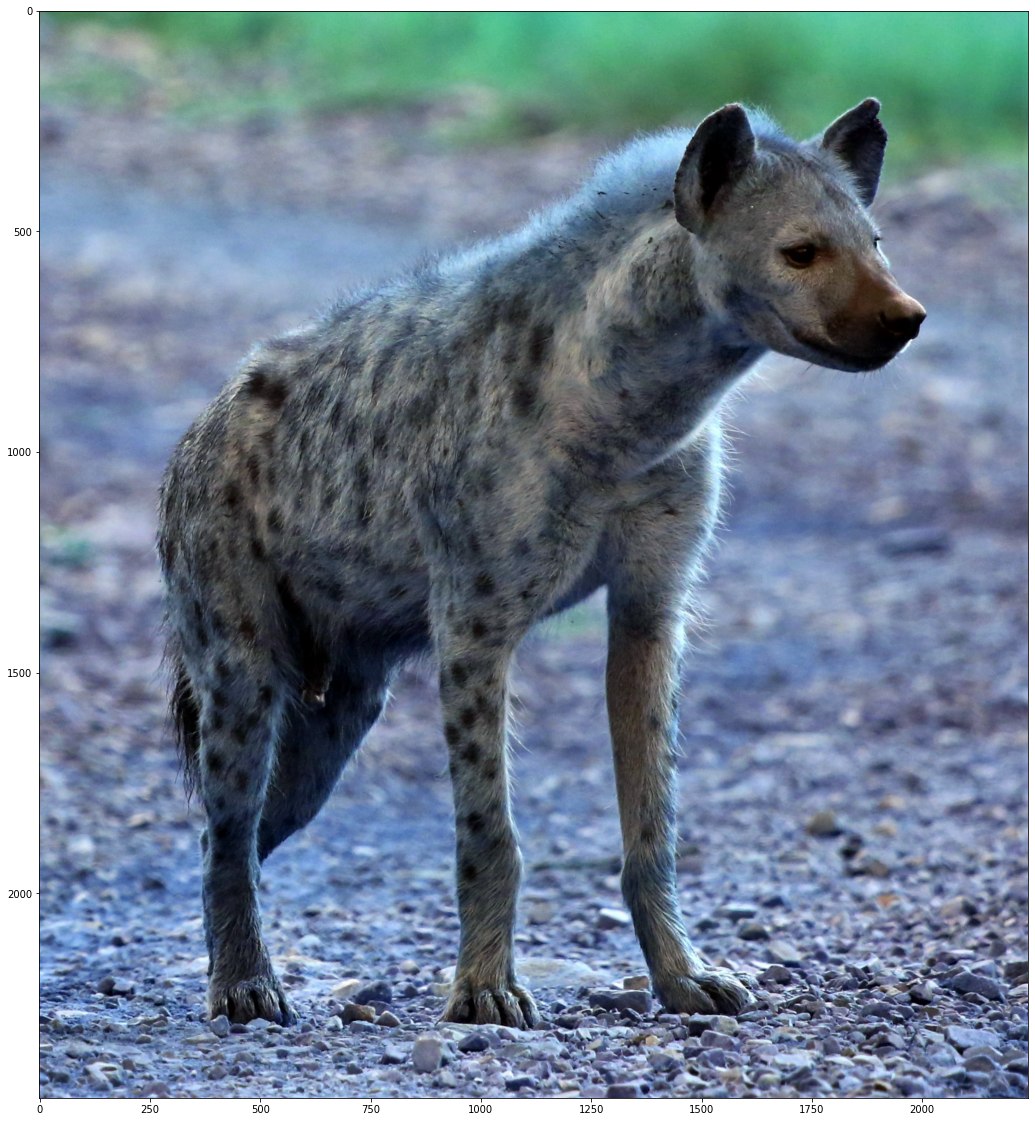

In [44]:
## image was uploaded before hand
img  = cv2.imread('./hyena.jpg')
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.float32(img) / 255
input_img = preprocess_image(img)


In [64]:
target_layers = [model.blocks[-1]] # define the target layer or iterate through many (it will average)


# for gradcam
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=use_cuda)
targets = [ClassifierOutputTarget(276)] # we can leave it None as well
grayscale_cam = cam(input_tensor=input_img, targets=None)

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
grayscale = cam(input_tensor=input_img, targets=targets)


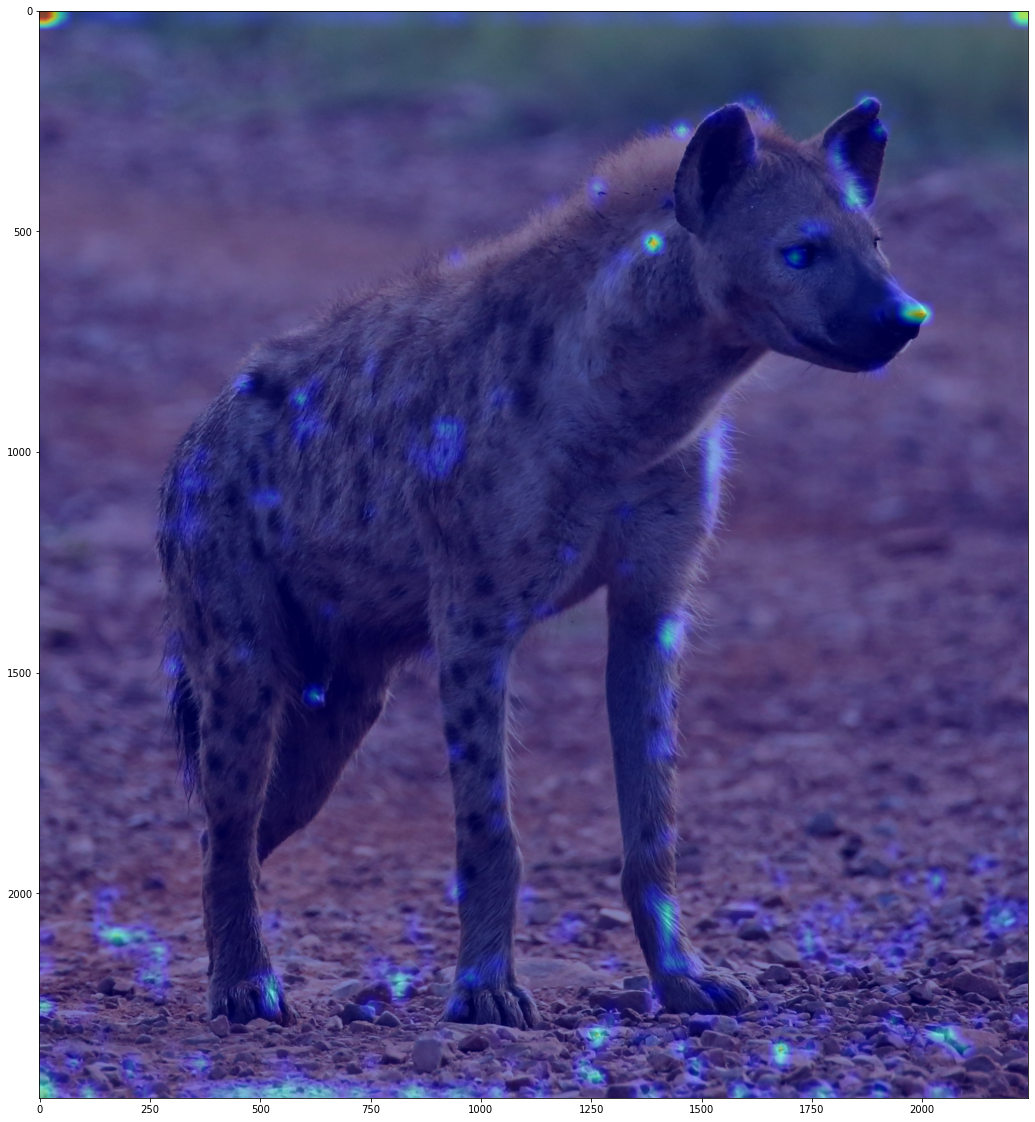

In [65]:
grayplus = grayscale_cam[0, :] #for single image squeezing it
grayplus = cv2.resize(grayplus, (img.shape[1], img.shape[0])) #resizing the heatmap
camplusplus = show_cam_on_image(img, grayplus,use_rgb=True ) #merging them together


gray = grayscale[0, :] #for single image squeezing it
gray = cv2.resize(gray, (img.shape[1], img.shape[0])) #resizing the heatmap
cam = show_cam_on_image(img, gray,use_rgb=True )
plt.imshow(cam) #just for cam

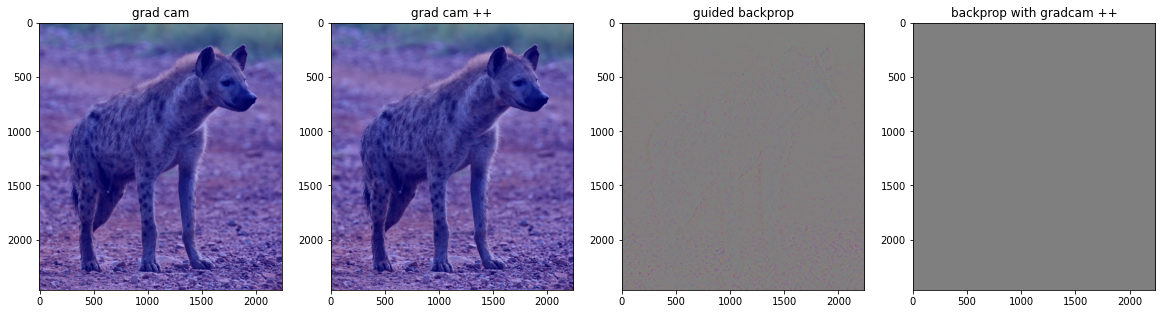

In [56]:
gb_model = GuidedBackpropReLUModel(model=model, use_cuda=use_cuda) # for guided backpropogation
gb = gb_model(input_img, target_category=None)
# gb = gb.transpose((1, 2, 0))


cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_re = cam_mask[0, :] #squeezing
cam_gb = deprocess_image(cam_re*gb)
gb = deprocess_image(gb)

fig, ax = plt.subplots(1,4)
ax[0].title.set_text('grad cam')
ax[1].title.set_text('grad cam ++')
ax[2].title.set_text('guided backprop')
ax[3].title.set_text('backprop with gradcam ++')
ax[0].imshow(cam)
ax[1].imshow(camplusplus)
ax[2].imshow(gb)
ax[3].imshow(cam_gb);

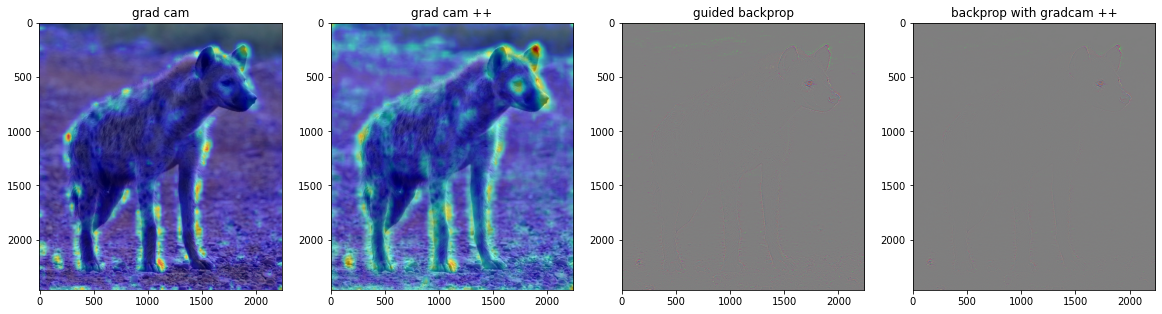

In [ ]:
# guided backprop with multiple  layers gradcam


gb_model = GuidedBackpropReLUModel(model=model, use_cuda=use_cuda) # for guided backpropogation
gb = gb_model(input_img, target_category=None)
# gb = gb.transpose((1, 2, 0))


cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_re = cam_mask[0, :] #squeezing
cam_gb = deprocess_image(cam_re*gb)
gb = deprocess_image(gb)

fig, ax = plt.subplots(1,4)
ax[0].title.set_text('grad cam')
ax[1].title.set_text('grad cam ++')
ax[2].title.set_text('guided backprop')
ax[3].title.set_text('backprop with gradcam ++')
ax[0].imshow(cam)
ax[1].imshow(camplusplus)
ax[2].imshow(gb)
ax[3].imshow(cam_gb);